# Introduction

In this notebook, I document some of the use cases that I imagine for the gAGDT and where I see possible development opportunity. Some of the use case are readily implemented, but some of them are rather complicated (at least for me).

At this moment I envisage at least two big classes of use cases, i.e.:
* query and visualization/browsing of the results
* modifying the results

For the purposes of this illustration I will only load some very basic modules: obviously, we need to interface with our graph.db and I'll use `py2neo` to do it. Then, I'll make use of the integration between cypher (Neo4j's query language) and Jupyter Notebook by using the cypher library for jupyter; I will also make use of the integration between Jupyter's cypher library and Python's `pandas`. Finally, I will show how I tried to implement some of the OGM logic (Object-Graph Mapping) of `py2neo` to the gAGDT. The [OGM interface](http://py2neo.org/v3/ogm.html) of `py2neo` offers you the opportunity to binding the graph nodes and entities to Python objects. For this, I have written a small module that can be found in the github repo under:

https://github.com/francescomambrini/gAGDT/object.py

In [1]:
from py2neo import Graph, Node, Relationship
from py2neo.ogm import GraphObject, Property, RelatedTo, RelatedFrom, RelatedObjects

In [2]:
from objects import Sentence, Token, Artificial

In [3]:
import pandas as pd

In [4]:
# loading the DB configurations (username and password)
import json
import os
with open(os.path.expanduser("~/.config/neo.json")) as f:
    conf = json.load(f)

In [6]:
g = Graph(password=conf["pwd"])
conn = "http://neo4j:{}@localhost:7474/db/data".format(conf["pwd"])

In [7]:
%load_ext cypher

In [8]:
%matplotlib inline

# Query

## Some basic use cases

### Most frequent substantives used as accusative objects of verbs

We want a list of the most used objects of the verbs in the AGDT. The requirements of this query are very easy:
* a governing node that has the Part of Speech (POS) "verb"
* a governed node that:
    * is linked to the governing node with the relation `OBJ`
    * has case = accusative
    * has pos = noun
    
We want a list with counts. This is very easily implemented in cypher and can be easily satisfied even by using Neo4j browser.

The query looks like this:

```cypher
MATCH (h:Token)-[r:Dependency {type : "OBJ"}]->(d:Token)
WHERE d.case = "accusative"
and h.pos = "verb"
and d.pos = "noun"
RETURN h.lemma as `Head`, d.lemma as `Dependent`, count(*) as `Tot` ORDER BY `Tot` DESC
```

Or even, in a more compat way, using the key:value syntax for node properties:

```cypher
MATCH (h:Token {pos : "verb"})-[r:Dependency {type : "OBJ"}]->(d:Token {pos : "noun", case : "accusative"})
RETURN h.lemma as `Head`, d.lemma as `Dependent`, count(*) as `Tot` ORDER by `Tot` DESC
```

(Note that with the `RETURN ... AS` statement we are just specifying a custom column name that we want to use for the result: it can be omitted)

Using the cypher integration in Jupyter this query is run like that:

In [9]:
res = %cypher {conn} MATCH (h:Token)-[r:Dependency]->(d:Token) \
    WHERE d.case = "accusative" \
    and h.pos = "verb" \
    and d.pos = "noun" \
    and r.type = "OBJ" \
    RETURN h.lemma as `Head`, d.lemma as `Dependent`, count(*) as `Tot` ORDER BY `Tot` DESC

7963 rows affected.


(Here we are saving the results to a python variable that we can reuse in our code).

One thing I *love* about using cypher from Jupyter is that you can immediately load the result of your query to a `pandas` DataFrame and then do all sort of data analysis that is supported by this more than awesome library. It is a easy as that: 

In [21]:
df = res.get_dataframe()

In [22]:
df.head()

,Head,Dependent,Tot
0,προσαυδάω,ἔπος,113
1,εἶπον,μῦθος,70
2,φημί,ἔπος,48
3,χέω,δάκρυον,41
4,πάσχω,ἄλγος,32


(Notice how the aliases we used in the `RETURN... AS...` statement of the query are now the column names of our DF. By default cypher would have returned the dotted name variable.property requested, e.g. `h.lemma`. Not as cool and, more importantly, not as handy for operations over DataFrame as what we have here...)

Say we want to chart the most frequently used objects of the verb "φημί". We re-write our query and we make use of `pandas` dataframe plotting methods. (Obviously, if we want more control over our plot, we can always import `matplotlib` or `seaborn` and use them with our dataframe)

In [9]:
q = '''MATCH (h:Token {pos : "verb", lemma : "φημί"})-[r:Dependency]->(d:Token {pos : "noun", case : "accusative"})
RETURN h.lemma as `Head`, d.lemma as `Dependent`, count(*) as `Tot` ORDER by `Tot` DESC
'''

In [10]:
res = %cypher {conn} {q}
df = res.get_dataframe()

7 rows affected.


In [11]:
df

,Head,Dependent,Tot
0,φημί,ἔπος,48
1,φημί,μῦθος,11
2,φημί,ἀντίον,2
3,φημί,μάχη,1
4,φημί,Πρίαμος,1
5,φημί,φήμη,1
6,φημί,ἀγγελία,1


[]

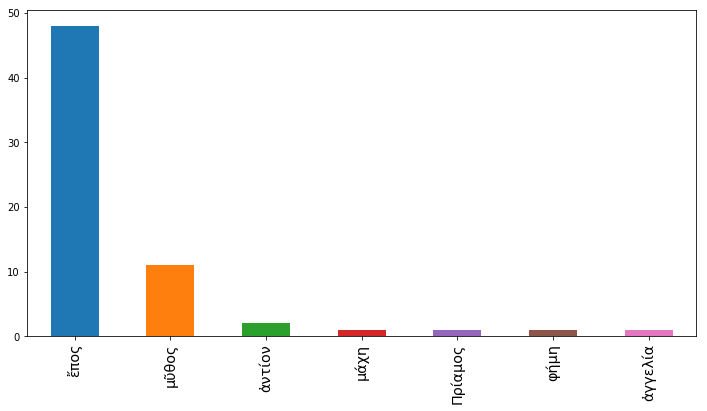

In [12]:
from matplotlib import pyplot as plt

ax = df.Tot.plot(kind="bar", figsize=(12,6))

# unfortunately, it's not very easy to set custom xtick labels from within
# the plotting function of a DataFrame. Use `pyplot`, change the index of the df
# or alternatively use the following code
ax.set_xticklabels(df.Dependent, rotation=90, fontsize="x-large")
ax.plot()

### Pie chart: how many verbs have expressed subjects

In [13]:
q = '''MATCH (s:Sentence{author:"Homer"})-[{type:"PRED"}]->(v:Token{pos:"verb"})-[{type:"SBJ"}]->(:Token)
with count(distinct(v)) as WithSBJ
MATCH (s:Sentence{author:"Homer"})-[{type:"PRED"}]->(v:Token{pos:"verb"})
where not (v)-[{type:"SBJ"}]->(:Token)
with count(*) as NoSBJ, WithSBJ
return WithSBJ as `With Sb expressed`, NoSBJ as `No Sb expressed`'''

In [14]:
res = %cypher {conn} {q}
df = res.get_dataframe()

1 rows affected.


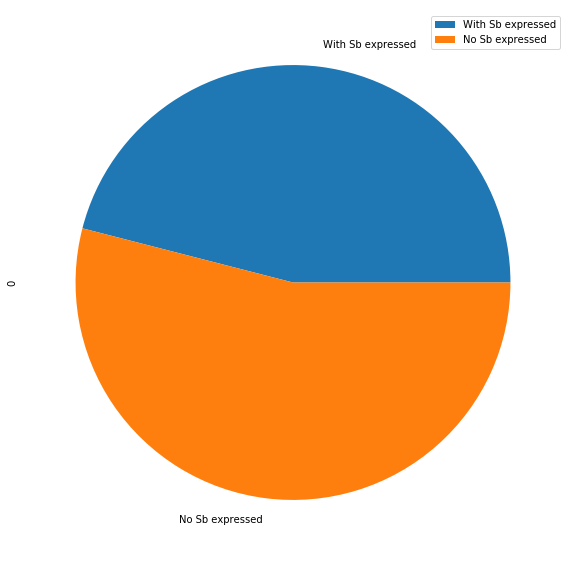

In [15]:
f = df.transpose().plot.pie(subplots=True, figsize=(20,10))



### Retrieve your results in a digital edition

With queries such as those that we used in the previous section, it is very easy to know exactly where in the text each of our matching nodes is found. It is sufficient to expand the previous query to have cypher return the `cts urn` of either the governing or the governed word. Luckily, thanks to a great design choice of the AGDT, this information is available. It is then very trivial to get a link from our result to Perseus to read our matching pattern in context.

In [13]:
# notice we're adding the h.cite in the return statement, 
# i.e the cts urn of the line where the governing verb is found
q = '''MATCH (h:Token {pos : "verb", lemma : "φημί"})-[r:Dependency {type : "OBJ"}]->(d:Token {pos : "noun", case : "accusative", lemma : 'μῦθος'})
RETURN h.lemma as `Head`, d.lemma as `Dependent`, h.cite as `Reference`'''

res = %cypher {conn} {q}
df = res.get_dataframe()

11 rows affected.


In [14]:
df

,Head,Dependent,Reference
0,φημί,μῦθος,urn:cts:greekLit:tlg0012.tlg001:21.393
1,φημί,μῦθος,urn:cts:greekLit:tlg0012.tlg001:21.471
2,φημί,μῦθος,urn:cts:greekLit:tlg0012.tlg001:23.491
3,φημί,μῦθος,urn:cts:greekLit:tlg0012.tlg001:24.598
4,φημί,μῦθος,urn:cts:greekLit:tlg0012.tlg002:13.37
5,φημί,μῦθος,urn:cts:greekLit:tlg0012.tlg002:15.171
6,φημί,μῦθος,urn:cts:greekLit:tlg0012.tlg002:2.384
7,φημί,μῦθος,urn:cts:greekLit:tlg0012.tlg002:20.326
8,φημί,μῦθος,urn:cts:greekLit:tlg0012.tlg002:21.67
9,φημί,μῦθος,urn:cts:greekLit:tlg0012.tlg002:6.148


You can pass each of those URN's as a parameter to a request to Perseus like this:

In [48]:
urn = df.Reference[0]
print("http://www.perseus.tufts.edu/hopper/text?doc={}".format(u))

http://www.perseus.tufts.edu/hopper/text?doc=urn:cts:greekLit:tlg0012.tlg001:21.393


With a bit of [`MyCapitain`](http://mycapytain.readthedocs.io/en/latest/) it would be possible to do much more sophisticated and appropriate stuff to retrieve the exact passage you're interested in (with, for instance, a given window of lines before and after the passage). That needs not concern us here.

### Visualize the results (in a meaningful way)

Say you want to visualize the 11 sentences where φημί governs μῦθος as object. This is unfortunately something I **cannot** do at the moment with the technologies and the code I have at hand. This doesn't sound to difficult to implement, but it's a lot of work and (most likely) it involves the use of languages (such as JavaScript) or libraries that I do not master at all!

Anyway, before we start coding we must be clear on the requirements! So here we go...

If you use the Neo4j browser and you visualize the results as a graph here is what the query above returns:

![graph](img/graph.png)

Cute, but this is definitely **NOT** what any user of a treebank would ever want!

The reason is that there is a crucial difference between an ordinary graph and a tree-*bank*. A treebank is a collection of peculiar graphs, i.e. the trees. Each sentence is a graph (a tree) on its own term. When we import a treebank in a graph db we're creating an "archipelago" of scattered islands-graphs, the sentences, that are not connected one to each other.

Maybe there is a better model for adapting a treebank to a graph db, but I haven't found it...

A consequence of this mismatch is that, whenever you're talking about visualizing the result of the query, you're actually talking about visualizing the relations within the matching nodes **within the context of each sentence** where those matches are found.

In other words, for the 11 matches above, what a user of a treebank expects is a series of 11 pages / 11 images displaying 11 sentences; each of the couples above are then marked wherever they appear in the sentence.

**This** is a closer representation of what a user would expect to see for each of the results (the image is relative to the result n. 4 in the DataFrame, *Od.* 13.37):

![screenshot](img/arethusa_screen.png)

Or even better, try to run this query on the online PML-TreeQuery that is made available by the Prague Dependency Treebank team and incorporate a conversion of the AGDT for a project named [HamleDT](https://ufal.mff.cuni.cz/hamledt). Go to the link below and click on "execute query"

http://hdl.handle.net/11346/PMLTQ-ML84

Copy-paste the following query in the textbox if something is wrong with the link above:

```perl
a-node $a :=  [
  lemma ~ 'φημ.',
  a-node [
    lemma ~ 'μ.+θος',
    afun = 'Obj',
  ]
];
```

This is a great way of visualizing the query result. Here's a list of the key features that make this visualization great (with some additional requirements expressed as "it would be great if..."):

* you have a linear representation of the sentence and the tree side by side
* the visualization is interactive: if you click on a node or a word:
    * the corresponding node/word in the other visualization (sentence or tree) is highlighted
    * it would be great if, by hovering/clicking on a node, I could visualize some additional properties of the node that are not shown in the tree (e.g. lemma)
* The nodes I have requested in my queries (verb φημί and object μῦθος) are higlighted with different colors
* I have a pagination of the 11 results
* It would be great if I could export the tree (with the highlighted nodes) as an img, even better a vectorial image (SVG, PDF)

Note that in cypher we will have to modify the query slightly if we want to obtain all the information we need to generate this visualization. Every time a user formulate a query that asks to retrieve all head-nodes governing a dependent via an OBJ relation and specify some property (e.g. the lemma) of node `d` and `h`, or:

```cypher
MATCH (h:Token {pos : "verb", lemma : "φημί"})-[r:OBJ]->(d:Token {pos : "noun", case : "accusative", lemma : 'μῦθος'})
```

we need to implicitly translate this request into a query that retrieves all the *sentences* that have a node `h` governing a node `d` as specified in the queries above:

```cypher
MATCH (s:Sentence)-[*]->(h:Token {pos : "verb", lemma : "φημί"})-[r:OBJ]->(d:Token {pos : "noun", case : "accusative", lemma : 'μῦθος'})
```

The first part, `(s:Sentence)-[*]->)`, will do the trick, as it asks for a `Sentence` node whose descendant (at any distance) is a node `h` governing a node `d`.

Alternatively, the sentence each node belongs to is always retrievable from the property `address` of the node, so you can always reconstruct what the ID of the sentence is.

## Object-graph Mapping

A little bit of Python will help you achiving a lot, actually, even in the direction of visualization!

With a mapping between Python objects and DB nodes (as explained [here](https://py2neo.org/v4/ogm.html#py2neo.ogm)) you can pratically create your own API to work with nodes and relations in your database. In this way, you can also leverage the functionality of Python's amazing [NLTK](http://www.nltk.org/) to work with **Dependency Graphs**.

For instance, you can use their function to visualize dependency trees. It's not exceptional, but it's something. Let's see...

In [29]:
s = Sentence.match(g, "tlg0011.tlg003.perseus-grc1#2383098#0").first()
s

<Sentence address='tlg0011.tlg003.perseus-grc1#2383098#0'>

In [30]:
depgraph = s._to_dep_graph(g)

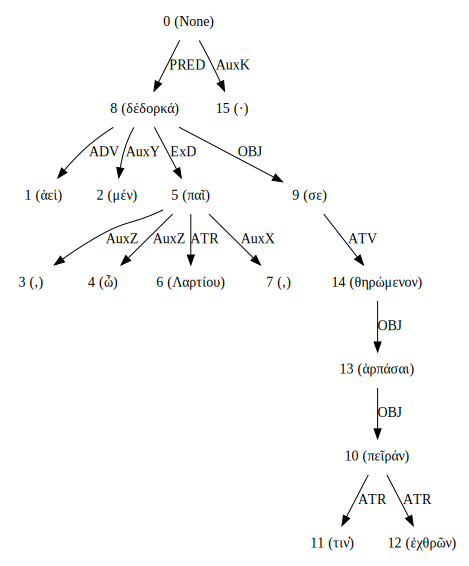

In [31]:
depgraph

In [36]:
t = depgraph.tree()
print(t)

(δέδορκά
  ἀεὶ
  μέν
  (παῖ , ὦ Λαρτίου ,)
  (σε (θηρώμενον (ἁρπάσαι (πεῖράν τιν̓ ἐχθρῶν)))))


# Editing the information in the DB

Editing the node properties and the relations in the DB is quite possible with the extant technologies and (especially) with the OGM interface of py2neo. However, it is not exactly easy or quick...

To give just one example, let us assume that in the current treebank in the sentence: `hi there, Mickey` the node `","` is attached to `"there"` and the administrator of the gAGDT thinks it is incorrect, for it should go with `"hi"`. If we want to use cypher (or the OGM library) you actually have to write two queries: one to detach `","` from `"there"`, one to attach it to `"hi"`. At the scale of 10, 20 or even more nodes in each sentence that becomes tedious soon enough (let alone, error-prone).

There are, however, more complicated use cases...

## Split nodes

The AGDT contains a few errors of tokenization. For instance the tokenizer in the treebank editor fails to recognize that words written as κἀγὼ are actually made up by two tokens (καί and ἐγώ) and should be tokenized as: κἀ and γὼ or κ and ἀγὼ (that is debatable, but perhaps this second version is better).\\

However, how can we make this correction in the DB? This apparently trivial operation translates into a list of non-trivial operation that must be performed. Let's consider one sentence in the XML format of the AGDT (Soph. *Aj.*, 24)

```xml
<sentence id='11' subdoc='24' document_id='urn:cts:greekLit:tlg0011.tlg003.perseus-grc1'>
    <word id='1' form='κἀγὼ' lemma='ἐγώ' postag='p-s---mn-' relation='SBJ' cite='urn:cts:greekLit:tlg0011.tlg003:24' head='5'/>
    <word id='2' form='̓' lemma='̓' postag='u--------' relation='AuxZ' cite='urn:cts:greekLit:tlg0011.tlg003:24' head='3'/>
    <word id='3' form='θελοντὴς' lemma='θελοντής' postag='n-s---mn-' relation='ATV' cite='urn:cts:greekLit:tlg0011.tlg003:24' head='1'/>
    <word id='4' form='τῷδ̓' lemma='ὅδε' postag='p-s---md-' relation='ATR' cite='urn:cts:greekLit:tlg0011.tlg003:24' head='6'/>
    <word id='5' form='ὑπεζύγην' lemma='ὑποζεύγνυμι' postag='v1saip---' relation='PRED' cite='urn:cts:greekLit:tlg0011.tlg003:24' head='0'/>
    <word id='6' form='πόνῳ' lemma='πόνος' postag='n-s---md-' relation='OBJ' cite='urn:cts:greekLit:tlg0011.tlg003:24' head='5'/>
    <word id='7' form='.' lemma='.' postag='u--------' relation='AuxK' cite='' head='0'/>
  </sentence>
```

The word with ID 1 should be split in two tokens. In place of a word we need two. But that, in turns, means that the current word with `rank` = 2 (this is the property of the gAGDT where we register the linear order) becomes `rank` = 3 and so on.

In the XML the `id` (our `rank`) is used to refer to the governing word in the `head` property. Nodes in the gAGDT have, at least for legacy reasons, a `head` property as well, that refers to the `rank` of the governing word. Strictly speaking, this is not needed in the gAGDT, because the dependency relation is otherwhise specified, but it may be handy (especially for format conversion) to have the head recorded as property of the nodes as well, as in the XML. That needs to be updated.

## Possible solutions

What I think would be very practical is a system that receives a tabular or xml input and automatically updates the properties and relations of the node in the sentence. By creating the nodes that are missing, deleting the nodes that do not exist anymore and updating all the properties of the nodes that needs to be updated.

Even better, the admins can have a graphical preview, where they can visualize their sentences before clicking on "update" to verify at a glance that they haven't done any mistake in the syntactical annotation.

---